In [1]:
import pandas as pd

from natsort import natsorted
from plotnine import *  # ggplot stuff

from lib.analysis import latency_bound_ats, latency_bound_sp
from lib.stream import Stream
from lib.topology import Topology, Switch, Host

In [2]:
PRIOS = (7, 6, 5, 4)

In [3]:
topo = Topology()
switches = [topo.add_node(Switch("sw1"))]
for i in range(2, 11):
    switches.append(topo.create_and_add_neigh(switches[-1], Switch("sw%d" % i), 1e9))
talker = topo.create_and_add_neigh(switches[0], Host("talker"), 1e9)
listener = topo.create_and_add_neigh(switches[-1], Host("listener"), 1e9)

In [4]:
topo.nodes

{'sw1': sw1,
 'sw2': sw2,
 'sw3': sw3,
 'sw4': sw4,
 'sw5': sw5,
 'sw6': sw6,
 'sw7': sw7,
 'sw8': sw8,
 'sw9': sw9,
 'sw10': sw10,
 'talker': talker,
 'listener': listener}

In [5]:
topo.links

{'sw1-sw2': sw1-sw2,
 'sw2-sw3': sw2-sw3,
 'sw3-sw4': sw3-sw4,
 'sw4-sw5': sw4-sw5,
 'sw5-sw6': sw5-sw6,
 'sw6-sw7': sw6-sw7,
 'sw7-sw8': sw7-sw8,
 'sw8-sw9': sw8-sw9,
 'sw10-sw9': sw10-sw9,
 'sw1-talker': sw1-talker,
 'listener-sw10': listener-sw10}

In [6]:
stream = Stream(label = "stream1",
                path = topo.shortest_path(talker, listener),
                priority = 7,
                rate = 5e6,  # 5 Mbits/s
                burst = 250*8,  # bits
                minFrameSize = 100*8,  # bits
                maxFrameSize = 500*8)  # bits
topo.add_stream(stream)

In [7]:
topo.streams_per_link

{'talker-sw1': {0: <lib.stream.Stream at 0x1adbada07c0>},
 'sw1-sw2': {0: <lib.stream.Stream at 0x1adbada07c0>},
 'sw2-sw3': {0: <lib.stream.Stream at 0x1adbada07c0>},
 'sw3-sw4': {0: <lib.stream.Stream at 0x1adbada07c0>},
 'sw4-sw5': {0: <lib.stream.Stream at 0x1adbada07c0>},
 'sw5-sw6': {0: <lib.stream.Stream at 0x1adbada07c0>},
 'sw6-sw7': {0: <lib.stream.Stream at 0x1adbada07c0>},
 'sw7-sw8': {0: <lib.stream.Stream at 0x1adbada07c0>},
 'sw8-sw9': {0: <lib.stream.Stream at 0x1adbada07c0>},
 'sw9-sw10': {0: <lib.stream.Stream at 0x1adbada07c0>},
 'sw10-listener': {0: <lib.stream.Stream at 0x1adbada07c0>}}

In [8]:
per_hop_guarantees = {7: 150e3,
                      6: 500e3,
                      5: 2e6,
                      4: 10e6}
topo.update_guarantees_all_links(per_hop_guarantees)  # this must be done before computing latency

In [9]:
topo.per_hop_guarantees

{'sw1-sw2': {7: 150000.0, 6: 500000.0, 5: 2000000.0, 4: 10000000.0},
 'sw2-sw1': {7: 150000.0, 6: 500000.0, 5: 2000000.0, 4: 10000000.0},
 'sw2-sw3': {7: 150000.0, 6: 500000.0, 5: 2000000.0, 4: 10000000.0},
 'sw3-sw2': {7: 150000.0, 6: 500000.0, 5: 2000000.0, 4: 10000000.0},
 'sw3-sw4': {7: 150000.0, 6: 500000.0, 5: 2000000.0, 4: 10000000.0},
 'sw4-sw3': {7: 150000.0, 6: 500000.0, 5: 2000000.0, 4: 10000000.0},
 'sw4-sw5': {7: 150000.0, 6: 500000.0, 5: 2000000.0, 4: 10000000.0},
 'sw5-sw4': {7: 150000.0, 6: 500000.0, 5: 2000000.0, 4: 10000000.0},
 'sw5-sw6': {7: 150000.0, 6: 500000.0, 5: 2000000.0, 4: 10000000.0},
 'sw6-sw5': {7: 150000.0, 6: 500000.0, 5: 2000000.0, 4: 10000000.0},
 'sw6-sw7': {7: 150000.0, 6: 500000.0, 5: 2000000.0, 4: 10000000.0},
 'sw7-sw6': {7: 150000.0, 6: 500000.0, 5: 2000000.0, 4: 10000000.0},
 'sw7-sw8': {7: 150000.0, 6: 500000.0, 5: 2000000.0, 4: 10000000.0},
 'sw8-sw7': {7: 150000.0, 6: 500000.0, 5: 2000000.0, 4: 10000000.0},
 'sw8-sw9': {7: 150000.0, 6: 50000

In [10]:
for i in range(len(switches) - 1):
    linkname = "%s-%s" % (switches[i].name, switches[i+1].name)
    print("Prio 7 link '%s' \t   SP latency: %.1f µs" % (linkname, latency_bound_sp(topo, linkname, 7) / 1e3), end="\t   ")
    print("ATS latency: %.1f µs" % (latency_bound_ats(topo, linkname, 7) / 1e3))

Prio 7 link 'sw1-sw2' 	   SP latency: 14.3 µs	   ATS latency: 14.3 µs
Prio 7 link 'sw2-sw3' 	   SP latency: 14.3 µs	   ATS latency: 14.3 µs
Prio 7 link 'sw3-sw4' 	   SP latency: 16.3 µs	   ATS latency: 14.3 µs
Prio 7 link 'sw4-sw5' 	   SP latency: 16.3 µs	   ATS latency: 14.3 µs
Prio 7 link 'sw5-sw6' 	   SP latency: 16.3 µs	   ATS latency: 14.3 µs
Prio 7 link 'sw6-sw7' 	   SP latency: 18.3 µs	   ATS latency: 14.3 µs
Prio 7 link 'sw7-sw8' 	   SP latency: 18.3 µs	   ATS latency: 14.3 µs
Prio 7 link 'sw8-sw9' 	   SP latency: 18.3 µs	   ATS latency: 14.3 µs
Prio 7 link 'sw9-sw10' 	   SP latency: 20.3 µs	   ATS latency: 14.3 µs


In [11]:
# Load all delays into a data frame
data = []
for link in topo.get_all_links_directed():
    for prio in PRIOS:
        data.append([link, prio, "SP", latency_bound_sp(topo, link, prio)])
        data.append([link, prio, "ATS", latency_bound_ats(topo, link, prio)])
df = pd.DataFrame(data, columns=["link", "priority", "type", "latency"])

In [12]:
df

,link,priority,type,latency
0,sw1-sw2,7,SP,14336
1,sw1-sw2,7,ATS,14336
2,sw1-sw2,6,SP,0
3,sw1-sw2,6,ATS,0
4,sw1-sw2,5,SP,0
...,...,...,...,...
171,sw10-listener,6,ATS,0
172,sw10-listener,5,SP,0
173,sw10-listener,5,ATS,0
174,sw10-listener,4,SP,0


In [13]:
# Remove links from end devices and those without delay
df = df.query("link.str.startswith('sw') and latency > 0", engine="python")

# Sort link names numerically (instead of alphabetically)
linknames_sorted = natsorted(df["link"].unique())
df = df.assign(link = pd.Categorical(df["link"], categories=linknames_sorted, ordered=True))

In [14]:
df

,link,priority,type,latency
0,sw1-sw2,7,SP,14336
1,sw1-sw2,7,ATS,14336
16,sw2-sw3,7,SP,14336
17,sw2-sw3,7,ATS,14336
32,sw3-sw4,7,SP,16336
33,sw3-sw4,7,ATS,14336
48,sw4-sw5,7,SP,16336
49,sw4-sw5,7,ATS,14336
64,sw5-sw6,7,SP,16336
65,sw5-sw6,7,ATS,14336


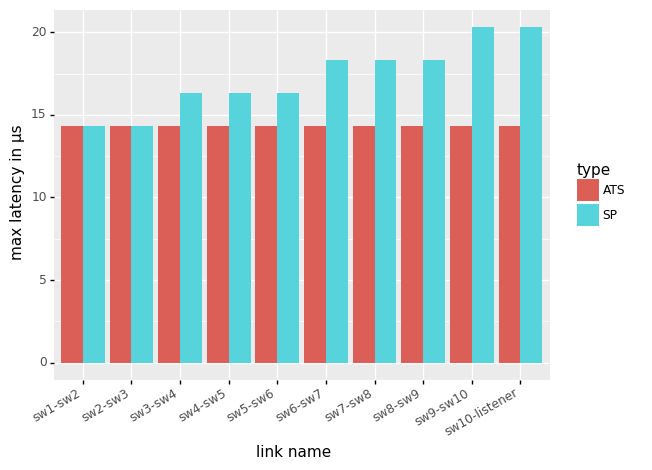

<ggplot: (115354778597)>

In [15]:
# Plot some information
plot = (ggplot(df)
        + aes(x="link", y="latency / 1e3", fill="type")
        + geom_bar(stat="identity", position="dodge")
        + labs(x="link name", y="max latency in µs")
        + theme(axis_text_x = element_text(angle=30, hjust=1))
        #+ geom_hline(yintercept = per_hop_guarantees[7] / 1e3)
)
plot

In [16]:
# Plot residence times of stream
residence_times = stream.get_residence_time_df(frame_count=6)
residence_times

,frame,hop,link,type,latency
0,1,1,talker-sw1,accMinLatency,800.0
1,1,1,talker-sw1,accMaxLatency,4000.0
2,1,2,sw1-sw2,accMinLatency,1600.0
3,1,2,sw1-sw2,accMaxLatency,154000.0
4,1,3,sw2-sw3,accMinLatency,2400.0
...,...,...,...,...,...
127,6,9,sw8-sw9,accMaxLatency,3204000.0
128,6,10,sw9-sw10,accMinLatency,2008000.0
129,6,10,sw9-sw10,accMaxLatency,3354000.0
130,6,11,sw10-listener,accMinLatency,2008800.0


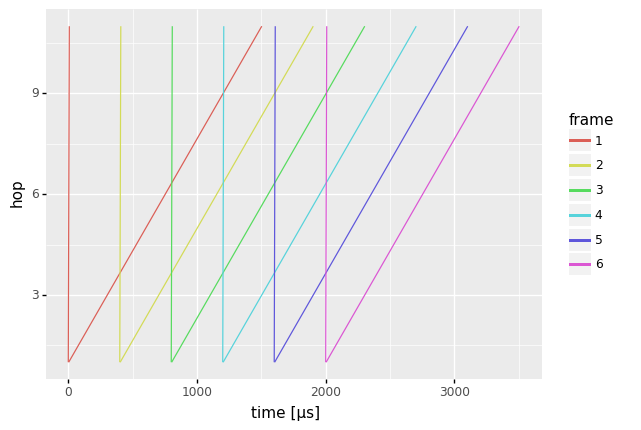

In [17]:
plot = (ggplot(residence_times)
        + aes(x="latency / 1e3", y="hop", color="frame", group="frame + type")
        + geom_line()
        + labs(x="time [µs]", y="hop", color="frame")
)
print(plot)

In [18]:
stream.rate

5000000.0

In [19]:
stream.burst / stream.rate * 1e9

400000.0

In [20]:
per_hop_guarantees

{7: 150000.0, 6: 500000.0, 5: 2000000.0, 4: 10000000.0}

In [21]:
stream2 = stream.clone()
stream2.rate = 500e3  # 500 kbit/s
stream2.priority = 6
topo.add_stream(stream2)
topo.update_guarantees_all_links(per_hop_guarantees)

In [22]:
stream2.accMaxLatencies

{'talker-sw1': 4000.0,
 'sw1-sw2': 504000.0,
 'sw2-sw3': 1004000.0,
 'sw3-sw4': 1504000.0,
 'sw4-sw5': 2004000.0,
 'sw5-sw6': 2504000.0,
 'sw6-sw7': 3004000.0,
 'sw7-sw8': 3504000.0,
 'sw8-sw9': 4004000.0,
 'sw9-sw10': 4504000.0,
 'sw10-listener': 5004000.0}

In [23]:
stream2.burst / stream2.rate * 1e9

4000000.0

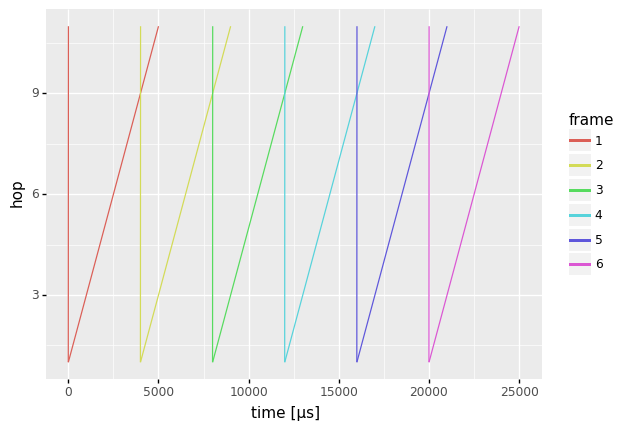

In [24]:
residence_times2 = stream2.get_residence_time_df(frame_count=6)
plot = (ggplot(residence_times2)
        + aes(x="latency / 1e3", y="hop", color="frame", group="frame + type")
        + geom_line()
        + labs(x="time [µs]", y="hop", color="frame")
)
print(plot)

In [25]:
# Let's add some more streams and compare latency on Hop 1
topo.remove_all_streams()
topo.add_stream(stream2)  # stream2 had prio 6

data = []
for i in range(130):
    streamx = stream.clone()  # stream had higher prio 7
    topo.add_stream(streamx)
    
    data.append([i, "SP", latency_bound_sp(topo, "sw1-sw2", 6)])
    data.append([i, "ATS", latency_bound_ats(topo, "sw1-sw2", 6)])
    
df2 = pd.DataFrame(data, columns=["additional_streams", "shaper", "latency"])
df2

,additional_streams,shaper,latency
0,0,SP,18336
1,0,ATS,16415
2,1,SP,22336
3,1,ATS,18514
4,2,SP,26336
...,...,...,...
255,127,ATS,749512
256,128,SP,530336
257,128,ATS,765691
258,129,SP,534336


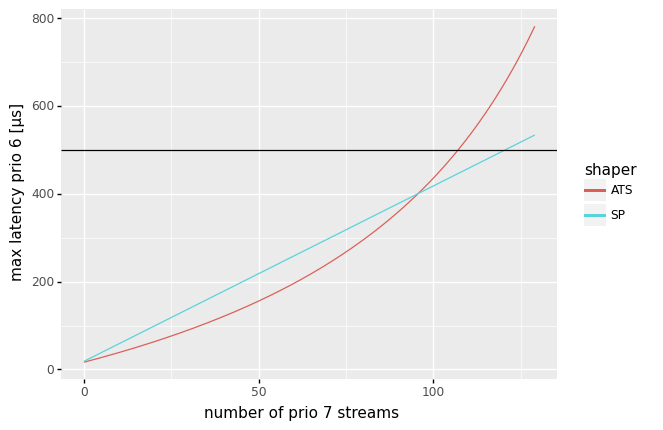

<ggplot: (115356963907)>

In [26]:
plot = (ggplot(df2)
        + aes(x="additional_streams", y="latency / 1e3", color="shaper")
        + geom_line()
        + labs(x="number of prio 7 streams", y="max latency prio 6 [µs]")
        + geom_hline(yintercept = per_hop_guarantees[6] / 1e3)
)
plot